In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import scipy


In [43]:
# Load in cleaned data
df_train = pd.read_csv("train_df_clean.csv")
df_test = pd.read_csv("test_df_clean.csv")

# Load in cleaned data without normalization
df_train_no_norm = pd.read_csv("train_df_clean_no_norm.csv")
df_test_no_norm = pd.read_csv("test_df_clean_no_norm.csv")


# Part 1

## Q1:

In [76]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors:int = 5):
        self.X_y = None
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_y=(X,y)
        return self

    def predict(self, X):
        # Note: You can use self.n_neighbors here
        predictions = None
        # TODO: compute the predicted labels (+1 or -1)
        dist = scipy.spatial.distance.cdist(X, self.X_y[0], 'euclidean')
        x_neighbors = np.argpartition(dist, self.n_neighbors)[:,:self.n_neighbors]
        y_pred=np.take(self.X_y[1],x_neighbors)
        predictions=scipy.stats.mode(y_pred, axis=1)[0]
        return predictions

In [70]:
def visualize_clf(clf, X, Y, title, marker_size=250):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(range(n_classes), palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

[0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1
 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1]
[[89]
 [89]
 [89]
 ...
 [27]
 [27]
 [27]]


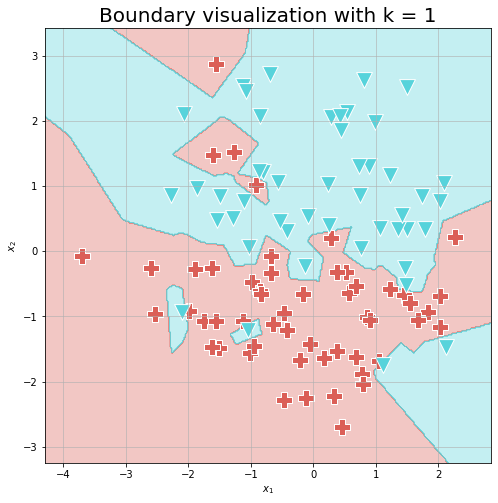

[0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1
 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1]
[[89 80  2 ... 29 51 42]
 [89 80  2 ... 29 51 42]
 [58 80  2 ... 51 29 42]
 ...
 [81 27 16 ... 31 24  9]
 [78 27 24 ... 81 31  9]
 [78 27 24 ... 81 31  9]]


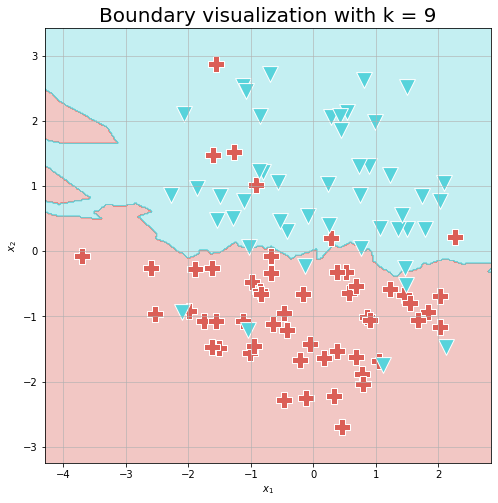

In [73]:
X_toy, y_toy = make_classification(n_samples=100, n_features=2,
                                   random_state=16, flip_y = 0.1,
                                   n_informative=2, n_redundant=0)
knn_1=kNN(1)
knn_1.fit(X_toy,y_toy)
visualize_clf(knn_1,X_toy, y_toy, "Boundary visualization with k = 1" )
knn_9=kNN(9)
knn_9.fit(X_toy,y_toy)
visualize_clf(knn_9,X_toy, y_toy, "Boundary visualization with k = 9" )

## Q2:

In [47]:
# Computes the correlation between spread  and the rest of the features

s = df_train.corr().spread.abs()
s.sort_values(kind="quicksort", ascending=False)

spread              1.000000
PCR_10              0.212723
PCR_07              0.042114
blood_A_AB          0.037510
PCR_01              0.022668
PCR_06              0.020925
covid               0.014039
PCR_02              0.013176
num_of_siblings     0.010719
household_income    0.008204
PCR_03              0.003534
risk                0.000343
sugar_levels        0.000150
Name: spread, dtype: float64

## Q3:

Text(0.5, 0, 'PCR_10')

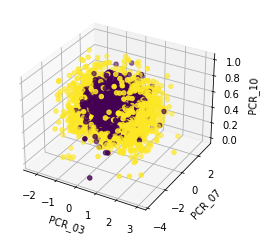

In [48]:
# Creates a 3d scatter plot of PCR_03, PCR_07, and PCR_10 with regards to spread

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(df_train.PCR_03, df_train.PCR_07, df_train.PCR_10, c=df_train.spread, marker='o')

ax.set_xlabel('PCR_03')
ax.set_ylabel('PCR_07')
ax.set_zlabel('PCR_10')

## Q5:

In [82]:
X=df_train_no_norm[['PCR_03', 'PCR_07', 'PCR_10']]
y=df_train_no_norm['spread'].values
knn_11=kNN(11)
knn_11.fit(X,y)
acc=knn_11.score(X,y)*100
print(f'{acc}%')

81.33333333333333%


## Q7:

In [83]:
X=df_train[['PCR_03', 'PCR_07', 'PCR_10']]
y=df_train['spread'].values
knn_11=kNN(11)
knn_11.fit(X,y)
acc=knn_11.score(X,y)*100
print(f'{acc}%')

87.91666666666667%


## Q8:

In [ ]:
features = [x for x in df_train.columns if x not in ['covid', 'risk', 'spread']]
_, axes = plt.subplots(len(features),2, figsize=(10, 5 * len(features)))
for i, col in enumerate(features):
    sns.histplot(df_train_no_norm, x=df_train_no_norm[col], ax=axes[i, 0])
    sns.histplot(df_train, x=df_train[col], ax=axes[i, 1])


# Part 2

## Q12:

In [ ]:
# Computes the correlation between risk and the rest of the features

s = df_train.corr().risk.abs()
s.sort_values(kind="quicksort", ascending=False)

## Q13:

In [ ]:
features = [x for x in df_train.columns if x not in ['covid', 'risk', 'spread']]
x_train = df_train[features]
y_train = df_train['risk']
x_test = df_test[features]
y_test = df_test['risk']
h = DecisionTreeClassifier(criterion="entropy", max_depth=4)
h.fit(x_train, y_train)
trainAcc = np.sum(h.predict(x_train) == y_train) * 100 / len(y_train)
plt.figure(figsize=(30, 20), dpi=200)
plot_tree(h, filled=True, feature_names=features, fontsize=10)

## Q15:

In [ ]:
clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), {'min_samples_leaf': np.arange(1, 16, 1),\
    'max_depth': np.arange(1, 16, 1)}, cv=8, return_train_score=True)
clf.fit(x_train, y_train)
grid_results = pd.DataFrame(clf.cv_results_)
train_acc = grid_results.pivot_table('mean_train_score', index='param_max_depth', columns='param_min_samples_leaf')
val_acc = grid_results.pivot_table('mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')
_, axes = plt.subplots(1, 2, figsize=(20, 10 ))
sns.heatmap(train_acc, cmap='YlGnBu', annot=True, ax=axes[0])
sns.heatmap(val_acc, cmap='YlGnBu', annot=True, ax=axes[1])
axes[0].set_xlabel("min_samples_leaf")
axes[1].set_xlabel("min_samples_leaf")
axes[0].set_ylabel("max_depth")
axes[1].set_ylabel("max_depth")


# Part 3

In [ ]:
class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        dim = hinge_inputs.size

        norm = np.linalg.norm(w)
        reg = norm ** 2

        # TODO: complete the loss calculation
        loss = reg + (C * np.maximum(np.zeros((dim, 1)), np.ones((dim, 1)) - hinge_inputs).sum())

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        f = np.where(hinge_inputs < 1, -1, 0)
        g_w = (2 * w) + C * (X * (f * y.reshape(-1, 1))).sum(axis=0)
        g_b = C * (f * y.reshape(-1, 1)).sum()

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step


            # TODO: update the learned parameters correctly
            self.w = self.w - (self.lr * (g_w / self.batch_size))
            self.b = self.b - (self.lr * (g_b / self.batch_size))

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
        """
        # TODO: compute the predicted labels (+1 or -1)

        y_pred = np.where((X.dot(self.w) + self.b) < 0, -1, 1)

        return y_pred

In [ ]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel('dist(analytic, numeric$_\delta$)', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


## Q16:

In [ ]:
y_train = df_train['covid']
compare_gradients(x_train.values, y_train.values, deltas=np.logspace(-5, -1, 9))

## Q17:

In [ ]:
clf = SoftSVM(C=1e2, lr=1e-5)
losses, accuracies = clf.fit_with_logs(x_train.values, y_train.values, max_iter=21500)
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1 = ax1.semilogy(losses, c='b', label='Loss')
ax2 = ax1.twinx()
line2 = ax2.plot(accuracies, c='r', label='Accuracy')
ax2.grid(alpha=0.5)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Loss", fontsize=18)
ax2.set_ylabel("Accuracy", fontsize=18)
ax1.set_xlabel("Number of Iterations", fontsize=18)
plt.title('SoftSVM Learning Curve for Covid CLass', fontsize=22)
plt.show()

## Q19:

In [ ]:
x_3feats = df_train[['PCR_03', 'PCR_07', 'PCR_10']]
y_3feats = df_train['spread']
trans = PolynomialFeatures(2)
x_3feats = trans.fit_transform(x_3feats)
val_acc = []
train_acc = []
for lr in np.logspace(-10, -1, 10):
    cv_results = cross_validate(SoftSVM(C=1000, lr=lr), x_3feats, y_3feats.values, cv=8, return_train_score=True)
    val_acc.append(np.mean(cv_results['test_score']))
    train_acc.append(np.mean(cv_results['train_score']))

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1 = ax1.plot(val_acc, c='b', label='Validation Accuracy')
ax2 = ax1.twinx()
line2 = ax2.plot(train_acc, c='r', label='Training Accuracy')
ax2.grid(alpha=0.5)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Accuracy", fontsize=18)
ax1.set_xlabel("Learning Rate", fontsize=18)
plt.xticks(np.arange(0, len(train_acc), 1), np.logspace(-10, -1, 10))
plt.title('Validation Curve for SoftSVM on Spread Class', fontsize=22)
plt.show()
print(np.logspace(-10, -1, 10))


